<h1> Training <code>shot_framing</code> </h1>

**Labels:**
* extreme-wide
* long
* medium
* medium close-up
* close-up
* extreme close-up

We only want to do transfer learning i.e. create a new head and train that alone, because we need the body to remain the same across different categories aka. MobileNetV2 pretrained on ImageNet

In [ ]:
# Dynamically load package
%load_ext autoreload
%autoreload 2

# Display multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from CinemaNet.convert import *
from fastai.vision import *
from fastai.callbacks import *
from ranger import Ranger
from CinemaNet.blend import *
from CinemaNet.wandb import *
from CinemaNet.custom_head import *
from CinemaNet.train_utils import to_film_ar # other utils will be redefined for clarity

import wandb

In [ ]:
model_name = 'cat_shot-framing_MNetV2-224x224_tfr-lrn'

In [ ]:
wandb.init(name    = f"{re.sub('cat_[a-z].*MN', 'MN', model_name)}",
           project = 'shot_framing',
           entity  = 'synopsis',
           reinit  = True)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/synopsis/shot_framing/runs/d17y2xem

In [ ]:
%env WANDB_NOTEBOOK_NAME='cat_shot-framing.ipynb'

env: WANDB_NOTEBOOK_NAME='cat_shot-framing.ipynb'


## Creating Train + Val Datasets

In [ ]:
path = Path('/home/rahul/datasets/Synopsis_Model_All_Concepts/shot_framing/')

In [ ]:
def get_labels(f):
    if re.search(f"{regex['EWS']}", str(f)): return 'shot_framing_extremewide'
    if re.search(f"{regex['LS']}",  str(f)): return 'shot_framing_long'
    if re.search(f"{regex['MS']}",  str(f)): return 'shot_framing_medium'
    if re.search(f"{regex['MCU']}", str(f)): return 'shot_framing_mediumclose'
    if re.search(f"{regex['CU']}",  str(f)): return 'shot_framing_close'
    if re.search(f"{regex['ECU']}", str(f)): return 'shot_framing_extremeclose'

In [ ]:
il_train = ImageList.from_folder(path/'train', presort=True)
il_valid = ImageList.from_folder(path/'valid', presort=True)
regex = {
    'CU' : '\/Close\-Up\/',
    'ECU': '\/Extreme Close\-Up\/',
    'EWS': '\/Extreme Wide\/',
    'LS' : '\/Long\/',
    'MS' : '\/Medium\/',
    'MCU': '\/Medium Close\-Up\/'
}

In [ ]:
lls = LabelLists(path,
                 train=il_train,
                 valid=il_valid)

In [ ]:
tfms = get_transforms(max_zoom=1.) # no zooming
tfms = tfms[0], []      # remove cropping tfm from validation-transforms

In [ ]:
img_size   = (224,224)
batch_size = 64

In [ ]:
data = (lls
        .label_from_func(get_labels)
        .transform(tfms=tfms, size=(224,224),
                   resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

In [ ]:
data

ImageDataBunch;

Train: LabelList (5505 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close
Path: /home/rahul/datasets/Synopsis_Model_All_Concepts/shot_framing/train;

Valid: LabelList (600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close,shot_framing_close
Path: /home/rahul/datasets/Synopsis_Model_All_Concepts/shot_framing/valid;

Test: None

In [ ]:
vc = pd.value_counts(data.train_ds.y.items, sort=False)
vc.index = data.classes
pd.DataFrame(vc)

0
shot_framing_close         1027
shot_framing_extremeclose  1237
shot_framing_extremewide    784
shot_framing_long           945
shot_framing_medium         631
shot_framing_mediumclose    881

In [ ]:
vc = pd.value_counts(data.valid_ds.y.items, sort=False)
vc.index = data.classes
pd.DataFrame(vc)

0
shot_framing_close         100
shot_framing_extremeclose  100
shot_framing_extremewide   100
shot_framing_long          100
shot_framing_medium        100
shot_framing_mediumclose   100

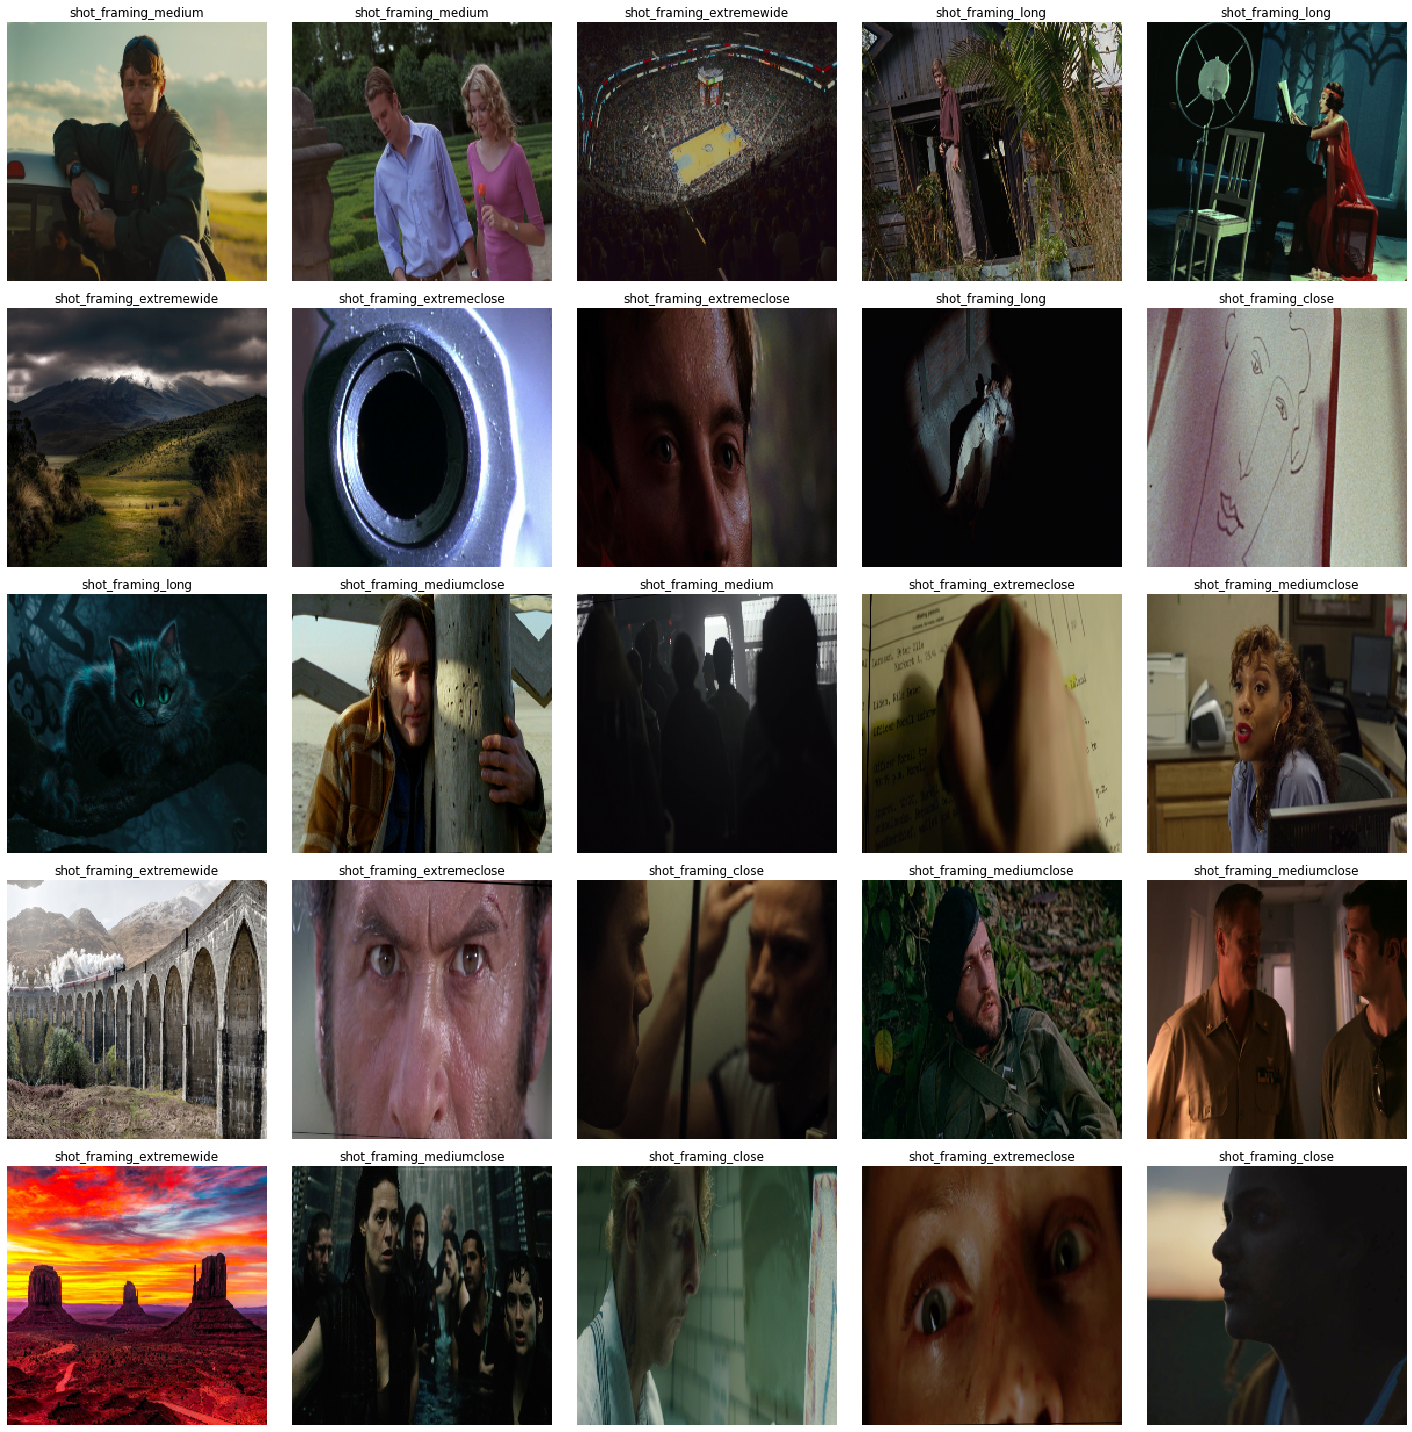

In [ ]:
data.show_batch()

## Model Setup

### Architecture, Loss Function, Optimiser

In [ ]:
arch = models.mobilenet_v2
loss_func = LabelSmoothingCrossEntropy()
opt_func  = Ranger

In [ ]:
model_name = f'{model_name}'
model_name

'cat_shot-framing_MNetV2-224x224_tfr-lrn'

In [ ]:
metrics = [accuracy, FBeta()]

def get_callbacks(learner, mod_name, monitor='fbeta'):
    return [
        #SaveModelCallback(learner, name=mod_name, monitor=monitor),
        CSVLogger        (learner, filename=f'{mod_name}-history'),
        WandbCallback    (learner, monitor=monitor, input_type='images',
                          log='all', predictions=100)
    ]

### Data Augmentations

`CutMix` is generally known to give better performance than `MixUp` (tentative), but this can be contextual.

Intuitively, `CutMix` is a good choice here, since you don't need to see the entire image to classify it. In the case of `shot_framing`, `MixUp` would be a better choice

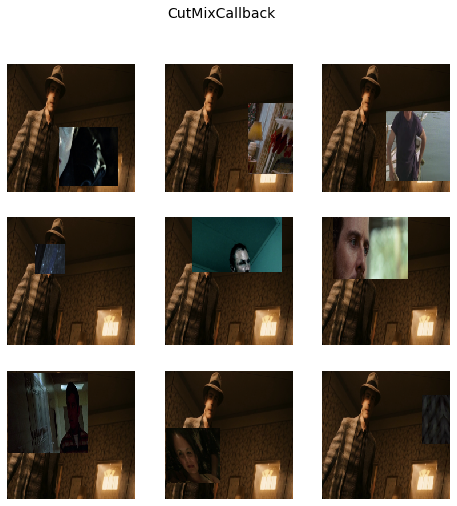

In [ ]:
_ = Learner(data,arch()).cutmix().show_tfms()

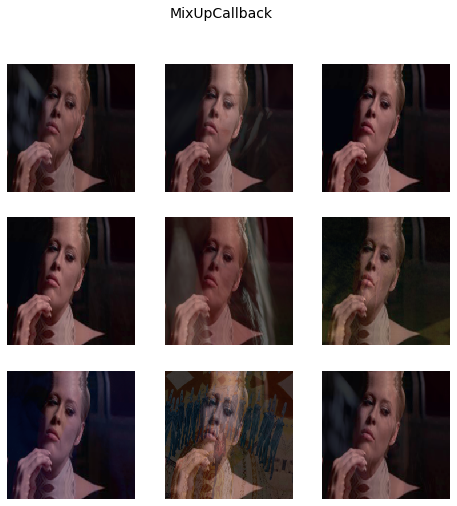

In [ ]:
_ = Learner(data,arch()).mixup().show_tfms()

### Model

In [ ]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics, opt_func=opt_func, 
                    loss_func=loss_func)
learn = learn.cutmix()

## Training

### Flat cosine annealing w/ Ranger (Lookahead + RAdam) Optimiser

In [ ]:
learn = cnn_learner(data, arch, bn_wd=False, 
                    metrics=metrics, opt_func=opt_func, 
                    loss_func=loss_func)
learn = learn.cutmix()

In [ ]:
learn.save(model_name) # avoid potential `SaveModelCallback` bugs

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 6.31E-02


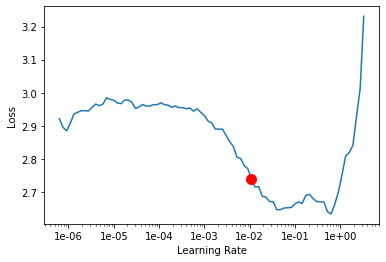

In [ ]:
learn.lr_find(wd=1e-2)
learn.recorder.plot(suggestion=True)

In [ ]:
model_name = f'{model_name}-opt_ranger-cosine_anneal'

In [ ]:
model_name

'cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal'

In [ ]:
callbacks = get_callbacks(learn, model_name, monitor='f_beta')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with f_beta value: 0.7576499581336975.
Better model found at epoch 1 with f_beta value: 0.8238375782966614.
Better model found at epoch 2 with f_beta value: 0.8602460622787476.
Better model found at epoch 3 with f_beta value: 0.9006636142730713.
Better model found at epoch 5 with f_beta value: 0.9121555089950562.
Better model found at epoch 12 with f_beta value: 0.9220168590545654.
Better model found at epoch 13 with f_beta value: 0.9268666505813599.
set state called
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_132356-d17y2xem/bestmodel.pth


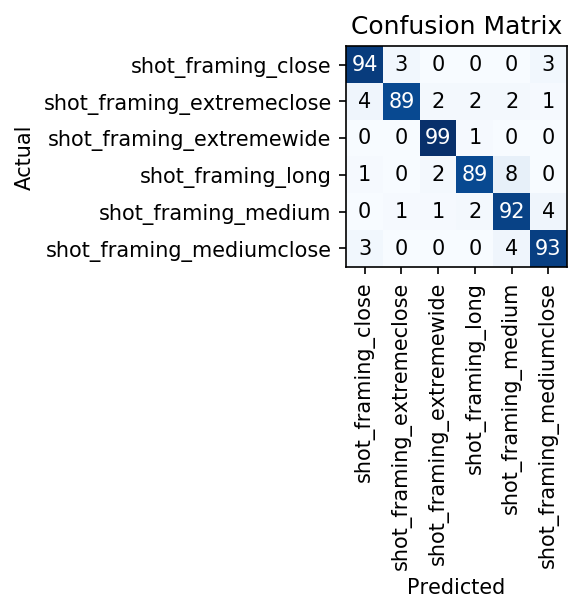

In [ ]:
# start_pct=0.5 --> start anneaing lr after 0.5*15 = 7.5 epochs
learn.fit_fc(15, 1e-2, wd=1e-2, callbacks=callbacks, start_pct=0.5)

In [ ]:
learn.save(model_name)

In [ ]:
model_name = f'{model_name}-extended'
callbacks = get_callbacks(learn, model_name, 'f_beta')

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


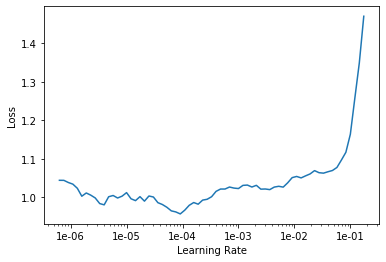

In [ ]:
learn.lr_find()
learn.recorder.plot()

/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with f_beta value: 0.9265121817588806.


wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
/home/rahul/fastai/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


set state called
Loaded best saved model from /home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_132356-d17y2xem/bestmodel.pth


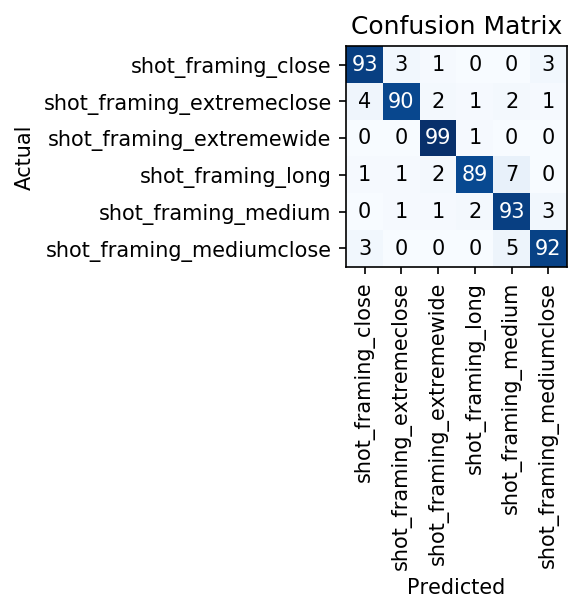

In [ ]:
learn.fit_one_cycle(15, slice(1e-6, 1e-3), wd=1e-2,
                    callbacks=callbacks)

In [ ]:
model_name

'cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal-extended'

In [ ]:
learn.save(model_name)

## Interpretation

In [ ]:
learn.load(model_name);

set state called


In [ ]:
interpret = learn.interpret()

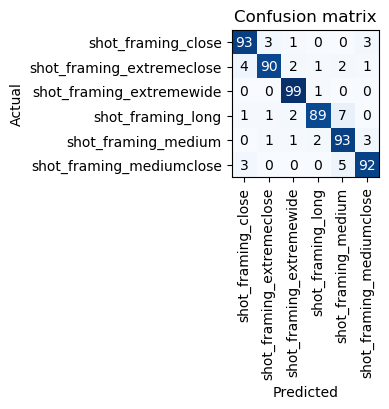

In [ ]:
interpret.plot_confusion_matrix(dpi=100)

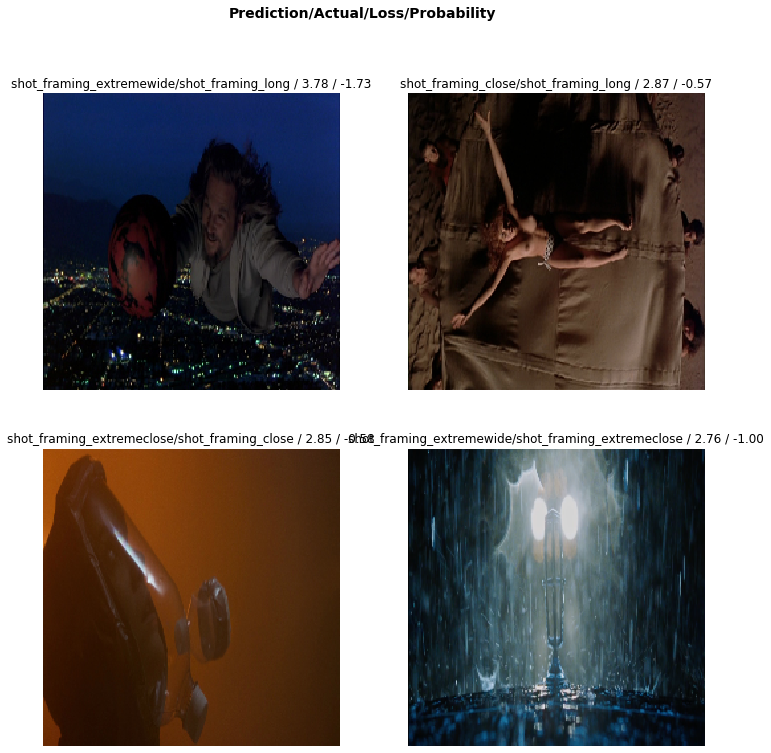

In [ ]:
interpret.plot_top_losses(4)

In [ ]:
interpret.most_confused()

[('shot_framing_long', 'shot_framing_medium', 7),
 ('shot_framing_mediumclose', 'shot_framing_medium', 5),
 ('shot_framing_extremeclose', 'shot_framing_close', 4),
 ('shot_framing_close', 'shot_framing_extremeclose', 3),
 ('shot_framing_close', 'shot_framing_mediumclose', 3),
 ('shot_framing_medium', 'shot_framing_mediumclose', 3),
 ('shot_framing_mediumclose', 'shot_framing_close', 3),
 ('shot_framing_extremeclose', 'shot_framing_extremewide', 2),
 ('shot_framing_extremeclose', 'shot_framing_medium', 2),
 ('shot_framing_long', 'shot_framing_extremewide', 2),
 ('shot_framing_medium', 'shot_framing_long', 2),
 ('shot_framing_close', 'shot_framing_extremewide', 1),
 ('shot_framing_extremeclose', 'shot_framing_long', 1),
 ('shot_framing_extremeclose', 'shot_framing_mediumclose', 1),
 ('shot_framing_extremewide', 'shot_framing_long', 1),
 ('shot_framing_long', 'shot_framing_close', 1),
 ('shot_framing_long', 'shot_framing_extremeclose', 1),
 ('shot_framing_medium', 'shot_framing_extremeclo

## Rename Files & Save to Weights & Biases

In [ ]:
model_name

'cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal-extended'

In [ ]:
learn.load(model_name); # this is just a sanity check, out callbacks would have loaded the best model anyways

set state called


In [ ]:
torch_to_coreml(learn.model, data.c, model_fname=f'{model_name}-FULL')

Converted PyTorch to ONNX
Converting ONNX to CoreML

1/162: Converting Node Type Conv
2/162: Converting Node Type BatchNormalization
3/162: Converting Node Type Clip
4/162: Converting Node Type Conv
5/162: Converting Node Type BatchNormalization
6/162: Converting Node Type Clip
7/162: Converting Node Type Conv
8/162: Converting Node Type BatchNormalization
9/162: Converting Node Type Conv
10/162: Converting Node Type BatchNormalization
11/162: Converting Node Type Clip
12/162: Converting Node Type Conv
13/162: Converting Node Type BatchNormalization
14/162: Converting Node Type Clip
15/162: Converting Node Type Conv
16/162: Converting Node Type BatchNormalization
17/162: Converting Node Type Conv
18/162: Converting Node Type BatchNormalization
19/162: Converting Node Type Clip
20/162: Converting Node Type Conv
21/162: Converting Node Type BatchNormalization
22/162: Converting Node Type Clip
23/162: Converting Node Type Conv
24/162: Converting Node Type BatchNormalization
25/162: Conver

In [ ]:
!ls -l ../exported-models/{model_name}*

-rw-rw-r-- 1 rahul rahul 14346850 Feb 10 19:47 ../exported-models/cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal-extended-FULL.mlmodel
-rw-rw-r-- 1 rahul rahul 14357317 Feb 10 19:47 ../exported-models/cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal-extended-FULL.onnx


In [ ]:
wandb.save(f'../exported-models/{model_name}*')

wandb: Wandb version 0.8.25 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


['/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_132356-d17y2xem/cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal-extended-FULL.onnx',
 '/home/rahul/github_projects/CinemaNet/nbs/wandb/run-20200210_132356-d17y2xem/cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal-extended-FULL.mlmodel']

In [ ]:
!ls {learn.path}/{model_name}*csv

/home/rahul/datasets/Synopsis_Model_All_Concepts/shot_framing/cat_shot-framing_MNetV2-224x224_tfr-lrn-opt_ranger-cosine_anneal-extended-history.csv


In [ ]:
wandb.save(f'{learn.path}/{model_name}*csv')

[]